In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Calculate uncertainties
Load the model from checkpoint and test on testset

In [3]:
# Load data
_, testset, inputs, num_classes = data.getDataset('POCUS')

ckpt_name = 'model_alexnet_lrt_relu_2023-10-04'

# Load model
ckpt = f'/home/marisa/Documents/PyTorch-BayesianCNN/checkpoints/POCUS/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type

net = getModel('alexnet', inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type)
net.load_state_dict(torch.load(ckpt)["model_state_dict"])
net.train() # should this be train or eval?
net.to(device)


found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Train/  :  1236
found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Test/  :  531


BBBAlexNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (conv5): BBBConv2d()
  (act5): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (classifier): BBBLinear()
)

In [4]:
def evaluate_uncertainties(model):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=25, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=25, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[pred], ale_norm[pred], epi_soft[pred], ale_soft[pred], truth==pred, truth, pred])


    return uncertainties


In [5]:
uncertainties = evaluate_uncertainties(net)

### Data inspection 
Look at the data with PCA and t-SNE

In [6]:
test_data = [elem[0].numpy().reshape(-1, 180*180).reshape(-1) for elem in testset]
test_labels = [elem[1] for elem in testset]

In [7]:
print('shape of test data: ', np.shape(test_data))

shape of test data:  (531, 32400)


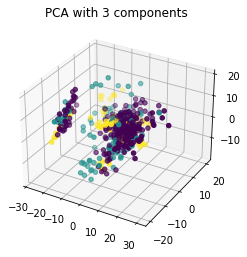

In [8]:
# PCA with 3 components
pca = PCA(n_components=3)

# fit the data (images) that is in the testset
pca_result = pca.fit_transform(test_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=[i[5] for i in uncertainties])
plt.title('PCA with 3 components')
plt.show()


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


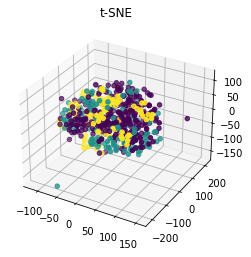

In [9]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
pca = PCA(n_components=30)
pca_result = pca.fit_transform(test_data)
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=[i[5] for i in uncertainties])
plt.title('t-SNE')
plt.show()


Check how many correct and wrong prediction there were

In [10]:
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and worng predictions there are for each class
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in uncertainties:
    if i[4]:
        right[int(i[5])] += 1
    else:
        wrong[int(i[5])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])


Class 0  -  Normal  -  Right: 256  ,  Wrong: 29
Class 1  -  Benign  -  Right: 67  ,  Wrong: 63
Class 2  -  Malignant  -  Right: 6  ,  Wrong: 110


In [11]:
# check how often which label was predicted and how often it was correct
pred = [0 for i in range(num_classes)]
correct = [0 for i in range(num_classes)]
for i in uncertainties:
    pred[int(i[6])] += 1
    if i[4]:
        correct[int(i[6])] += 1

for i in range(num_classes):
    print('Class', i, ' - Prediction ', class_names[i] , ' - ', 'Predicted:', pred[i], ' , ', 'of which were correct:', correct[i])


Class 0  - Prediction  Normal  -  Predicted: 358  ,  of which were correct: 256
Class 1  - Prediction  Benign  -  Predicted: 166  ,  of which were correct: 67
Class 2  - Prediction  Malignant  -  Predicted: 7  ,  of which were correct: 6


check range of uncertainties


In [12]:
print('Epistemic Uncertainty (Normalized):', min([i[0] for i in uncertainties]), max([i[0] for i in uncertainties]))
print('Aleatoric Uncertainty (Normalized):', min([i[1] for i in uncertainties]), max([i[1] for i in uncertainties]))
print('Epistemic Uncertainty (Softmax):', min([i[2] for i in uncertainties]), max([i[2] for i in uncertainties]))
print('Aleatoric Uncertainty (Softmax):', min([i[3] for i in uncertainties]), max([i[3] for i in uncertainties]))

Epistemic Uncertainty (Normalized): 0.0013038499 0.014620117
Aleatoric Uncertainty (Normalized): 0.1892497 0.24834327
Epistemic Uncertainty (Softmax): 0.0019320259 0.065308765
Aleatoric Uncertainty (Softmax): 0.037832737 0.23940843


### Uncertainty visualization

Normalized epistemic uncertainty

In [13]:
def sort_uncertainties(u_type, normalized, uncertainties):
    
    # get the correct index at which the uncertainty is stored
    if u_type == 'epistemic':
        if normalized:
            u = 0
        else:
            u = 2
    elif u_type == 'aleatoric':
        if normalized:
            u = 1
        else:
            u = 3
    
    # split the testset into 5 groups based on epistemic uncertainty (normalized)
    testset0, testset1, testset2, testset3, testset4 = [], [], [], [], []
    labels0, labels1, labels2, labels3, labels4 = [], [], [], [], []

    # create thresholds 
    t0 = min([i[0] for i in uncertainties])
    t5 = max([i[0] for i in uncertainties])
    steps = (t5-t0) / 5

    t1 = t0 + steps
    t2 = t1 + steps
    t3 = t2 + steps
    t4 = t3 + steps

    for i, elem in enumerate(uncertainties):
        if elem[u] < t1:
            testset0.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
            labels0.append(elem[5])
        elif elem[u] < t2:
            testset1.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
            labels1.append(elem[5])
        elif elem[u] < t3:
            testset2.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
            labels2.append(elem[5])
        elif elem[u] < t4:
            testset3.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
            labels3.append(elem[5])
        else:
            testset4.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
            labels4.append(elem[5])

    testsets = [testset0, testset1, testset2, testset3, testset4]
    thresholds = [t0, t1, t2, t3, t4, t5]
    labelssets = [labels0, labels1, labels2, labels3, labels4]
    vals = ["small", "small-medium", "medium", "medium-large", "large"]

    return testsets, thresholds, labelssets, vals


In [14]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
def plot_tsne(uncertainties, u_type='epistemic', normalized=True):

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type, normalized, uncertainties)

    for i in range(len(testsets)):
        set_i = testsets[i]
        labels_i = labelssets[i]
        if len(labels_i) < 30:
            n_components = len(labels_i)
        else:
            n_components = 30
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(set_i)
        tsne = TSNE(n_components=3)
        tsne_result = tsne.fit_transform(pca_result)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=labels_i)
        plt.title('t-SNE for ' + vals[i] + ' epistemic uncertainty (normalized) (between ' + str(thresholds[i]) + ' and ' + str(thresholds[i+1]) + ')')
        plt.show()

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


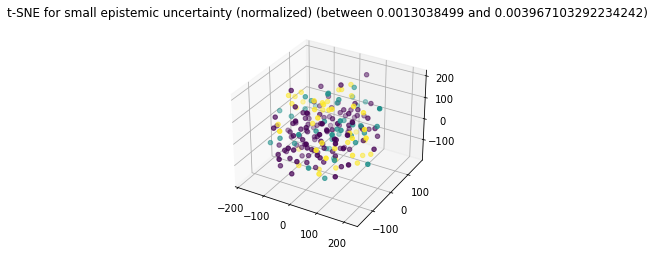

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


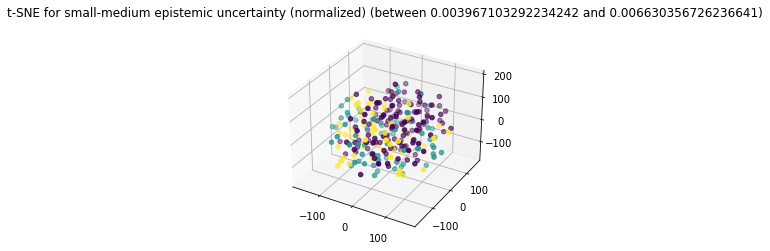

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


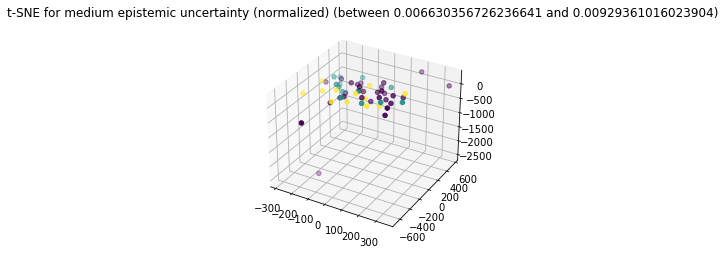

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


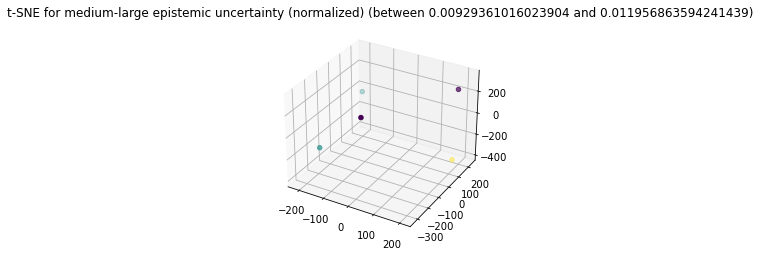

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required.

In [15]:
plot_tsne(uncertainties, u_type='epistemic', normalized=True)

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


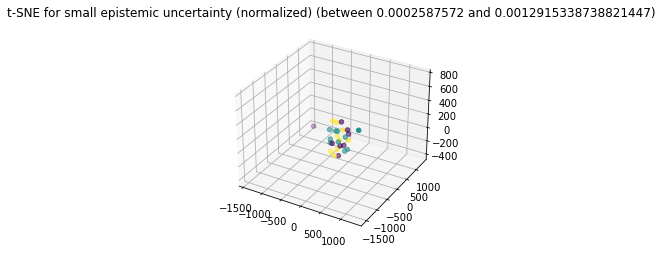

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


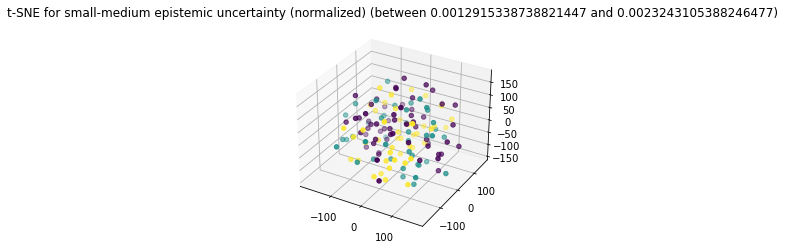

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


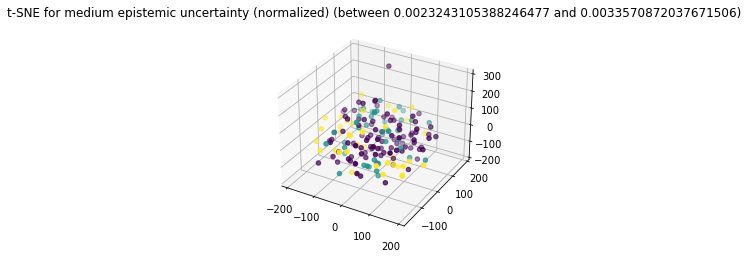

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


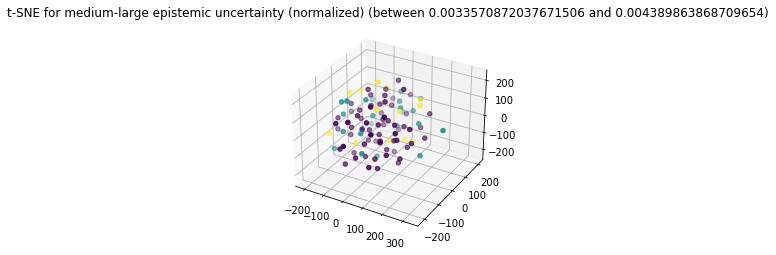

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


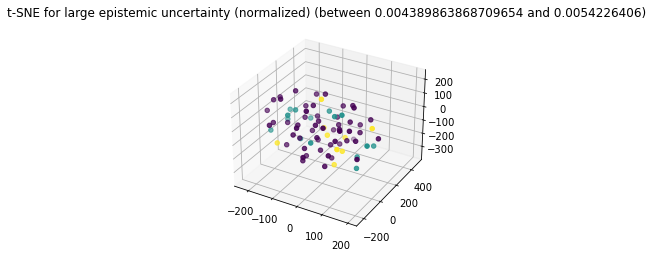

In [ ]:
plot_tsne(uncertainties, u_type='epistemic', normalized=False)

In [ ]:
plot_tsne(uncertainties, u_type='aleatoric', normalized=True)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
plot_tsne(uncertainties, u_type='aleatoric', normalized=False)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Calculate the accuracy for the different subsets